In [1]:
"""HW 2"""
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp


%matplotlib inline


In [5]:
"""Problem 1: The Power Method"""
class SpectralDecompositionPowerMethod:
    """
    Store the output vector in the object attribute self.components_ and the 
    associated eigenvalue in the object attribute self.singular_values_ 
    
    Why this code structure and attribute names? We are using the convention used by 
    the popular scikit-learn machine learning library:
    https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html

    Parameters
        max_iter (int): maximum number of iterations to for the calculation
        tolerance (float): fractional change in solution to stop iteration early
        gamma (float): momentum parameter for the power method
        random_state (int): random seed for reproducibility
        store_intermediate_results (bool): whether to store the intermediate results as
            the power method iterates
        stored_eigenvalues (list): If store_intermediate_results is active, a list of 
            eigenvalues at each iteration
        stored_eigenvectors (list): If store_intermediate_results is active, a list of
            eigenvectors at each iteration
    
    """
    def __init__(self, 
        max_iter=1000, 
        tolerance=1e-5, 
        gamma=0.0,
        random_state=None, 
        store_intermediate_results=False
    ):
        self.max_iter = max_iter
        self.tolerance = tolerance
        self.gamma = gamma
        self.random_state = random_state
        self.store_intermediate_results = store_intermediate_results
        #initialize lists
        if self.store_intermediate_results:
            self.eigenvalues = list()
            self.eigenvectors = list()
        
        #Create values to be returned at the end of the fit method
        self.singular_values_ = None
        self.components_ = None

    
    def fit(self, A):
        """
        Perform the power method with random initialization, and optionally store
        intermediate estimates of the eigenvalue and eigenvectors at each iteration.
        You can add an early stopping criterion based on the tolerance parameter.
        """
        """Define a random vector w"""
        # Pick out the number of rows of A 
        n = np.shape(A)[0]
        #Seed the random function
        np.random.seed(self.random_state)
        #Define a random vector w with dimensions matching A
        w = np.random.random(n)
        #Convert w into a unit vector
        w = w/np.linalg.norm(w)
        
        #Since the magnitude of this vector gives the leading eigenvalues
        #store these values
        if self.store_intermediate_results:
            self.eigenvalues.append(1)
            self.eigenvectors.append(w)
        
        for i in range(self.max_iter):
            old = np.copy(w)
            new = A.dot(w)
            eigenv = np.linalg.norm(new)
            w = new/eigenv
            
            #Add momentum term to 
            w = self.gamma*old + (1-self.gamma)*w


            if self.store_intermediate_results:
                self.eigenvalues.append(eigenv)
                self.eigenvectors.append(w)

            
            #If the vector value difference drops below a certain tolerance, stop the Power Method
            if  np.mean(np.sqrt((w-old)**2)/old**2) < self.tolerance:
                break
        
        #Turn the stored lists into actionable arrays
        if self.store_intermediate_results:
            self.eigenvalues = np.array(self.eigenvalues)
            self.eigenvectors = np.array(self.eigenvectors)
        
        #Set the final value (avoiding reference for speed)

        self.singular_values_ = eigenv
        self.components_ = w


## Use the default eigensystem calculator in numpy as a point of comparison
def eigmax_numpy(A):
    """
    Compute the maximum eigenvalue and associated eigenvector in a matrix with Numpy.
    """
    eigsys = np.linalg.eig(A)
    a = np.abs(eigsys[0])
    ind = np.argmax(a)
    return np.real(eigsys[0][ind]), np.real(eigsys[1][:, ind])

10.618581948982042
Power method solution: 0.031962709250142676
Numpy solution: 0.03196269086605738


Text(0, 0.5, 'Power method eigenvector')

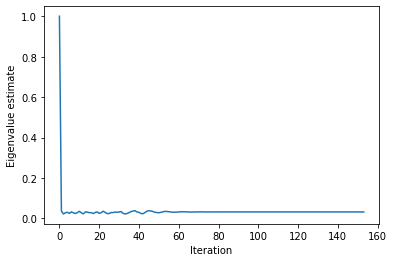

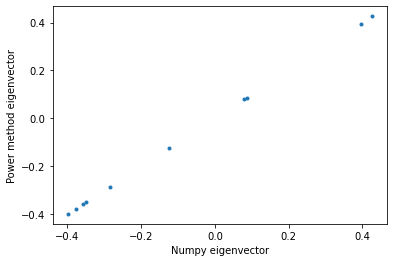

In [7]:

# np.random.seed(2) # for reproducibility
#mm = np.random.random(size=(10, 10))/100
mm = np.random.normal(size=(10, 10)) / 100 # these matrices fail to converge more often

print(np.linalg.cond(mm.T))
model = SpectralDecompositionPowerMethod(store_intermediate_results=True)
model.fit(mm);


print(f"Power method solution: {model.singular_values_}")
print(f"Numpy solution: {eigmax_numpy(mm)[0]}")

plt.figure()
plt.plot(model.eigenvalues)
plt.xlabel("Iteration")
plt.ylabel("Eigenvalue estimate")

plt.figure()
plt.plot(eigmax_numpy(mm)[1], model.components_, '.')
plt.xlabel("Numpy eigenvector")
plt.ylabel("Power method eigenvector")

2. Sometimes you'll notice that the power method fails to converge to the correct solution. What is special about randomly-sampled matrices where this occurs? How does the direction of the starting vector affect the time it takes to reach a solution?

These matrices are close to being singular which means there are eigenvalues which are close to being zero. If the leading eigenvalue that we're seeking for is close to zero, then the repeated application of the transformation matrix will likely only make small changes and the algorithm will fail to converge. The leading (i.e. largest) eigenvector of the matrix tend to pull the starting vector to align with itself, so if this starting vector is intially aligned with the matrix eigenvector, this aligning can happen quickly. Otherwise, it can take much longer.

3. Suppose we interpret that a given linear matrix X describes a discrete-time linear dynamical system. What kind of dynamics does the power method exhibit? What about the pathological cases you discuused in the previous solution?

This system would gradually align and alter the shape of the starting vector to match the leading eigenvector of the linear matrix. Each iteration would transform the starting vector into a shape more aligned with that eigenvector. 

4. How would you modify the power method to implement momentum? What pathological dynamics does this momentum help avoid?

The momentum term is labeled in the above code. This term gives an additional "nudge" to the transformed vector during each iteration. If close to singular eigenvalues threaten to stall the transformation, this momentum gives an added "kick" to push the vector and restart the process.

5. What kind of dynamics would a damping term help us avoid?

With the momentum term, the danger is OVERSHOOTING the desired eigenvector during our iterative transformations. This damping term would constrain the size of the transformation and prevent "eternal oscillation".

In [8]:
"""Problem 2: Principal Component Analysis and Unsupervised Learning"""

'Problem 2: Principal Component Analysis and Unsupervised Learning'

In [9]:
Re = 300 # Reynolds number, change this to 300, 600, 900, 1200

# Load the two-dimensional velocity field data. Data is stored in a 4D numpy array,
# where the first dimension is the time index, the second and third dimensions are the
# x and y coordinates, and the fourth dimension is the velocity components (ux or uv).
vfield = np.load(
    f"C:/Users/i-lov/OneDrive - The University of Texas at Austin/Desktop/cphy/HW/resources/von_karman_street/vortex_street_velocities_Re_{Re}_largefile.npz", 
    allow_pickle=True
)
print("Velocity field data has shape: {}".format(vfield.shape))

# Calculate the vorticity, which is the curl of the velocity field
vort_field = np.diff(vfield, axis=1)[..., :-1, 1] + np.diff(vfield, axis=2)[:, :-1, :, 0] 

Velocity field data has shape: (3000, 256, 128, 2)


In [11]:
from sklearn.base import BaseEstimator, TransformerMixin

# We are going to use class inheritance to define our object. The two base classes from
# scikit-learn represent placeholder objects for working with datasets. They include 
# many generic methods, like fetching parameters, getting the data shape, etc.
# 
# By inheriting from these classes, we ensure that our object will have access to these
# functions, even though we don't have to define them ourselves
class PrincipalComponents(BaseEstimator, TransformerMixin):
    """
    A class for performing principal component analysis on a dataset.
    """

    def __init__(self, random_state=None):
        self.random_state = random_state
        self.components_ = None
        self.singular_values_ = None

    def fit(self, X):
        """
        Fit the PCA model to the data X. Store the eigenvectors in the attribute
        self.components_ and the eigenvalues in the attribute self.singular_values_

        Args:
            X (np.ndarray): A 2D array of shape (n_samples, n_features) containing the
                data to be fit.
        
        Returns:
            self (PrincipalComponents): The fitted object.
        """
        
        X_C = X
        Sig = np.transpose(X_C).dot(X_C)/X_C.shape[0]
        eva, evec = np.linalg.eigh(Sig)
        #Since the covariance matrix is the eigenvectors stacked on one another, we need to take the transpose of the column vector matrix
        evec = evec.T
        #Organizing the positions of the eigenvalues by decreasing order since this order will correspon with the eigenvectors
        sort_pos = np.argsort(eva)[::-1]
        #Apply this order to the actual sets
        eva, evec = eva[sort_pos], evec[sort_pos]

        self.components_ = evec
        self.singular_values_ = eva

        return self

    def transform(self, X):
        """
        Transform the data X into the new basis using the PCA components.

        Args:
            X (np.ndarray): A 2D array of shape (n_samples, n_features) containing the
                data to be transformed.

        Returns:
            X_new (np.ndarray): A 2D array of shape (n_samples, n_components) containing
                the transformed data. n_components <= n_features, depending on whether
                we truncated the eigensystem.
        """
        self.fit(X)
        #Define the mean data matrix again
        X_C = X - np.mean(X,axis=0)
        #Transform the data using the PCA eigenvectors
        X_new = X_C.dot(self.components_.T)
     
        return X_new

    
    def inverse_transform(self, X):
        """
        Transform from principal components space back to the original space

        Args:
            X (np.ndarray): A 2D array of shape (n_samples, n_components) containing the
                data to be transformed. n_components <= n_features, depending on whether
                we truncated the eigensystem.

        Returns:
            X_new (np.ndarray): A 2D array of shape (n_samples, n_features) containing
                the transformed data.
        """
        #Undo the PCA transformation from transform
        final = X.dot(self.components_) + np.mean(X, axis=0)
        return final

Text(0, 0.5, 'Eigenvalue rank')

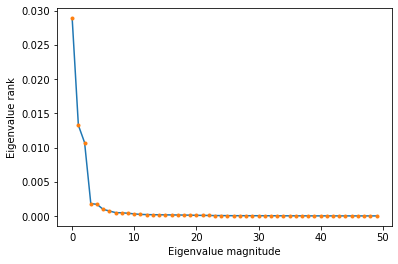

In [12]:
data = np.copy(vort_field)[::3, ::2, ::2] # subsample data to reduce compute load
data_reshaped = np.reshape(data, (data.shape[0], -1))

model = PrincipalComponents()
# model = PCA()

data_transformed = model.transform(data_reshaped)
principal_components = np.reshape(
    model.components_, (model.components_.shape[0], data.shape[1], data.shape[2])
)

## Look at skree plot, and identify the "elbow" indicating low dimensionality
plt.figure()
plt.plot(model.singular_values_[:50])
plt.plot(model.singular_values_[:50], '.')
plt.xlabel("Eigenvalue magnitude")
plt.ylabel("Eigenvalue rank")

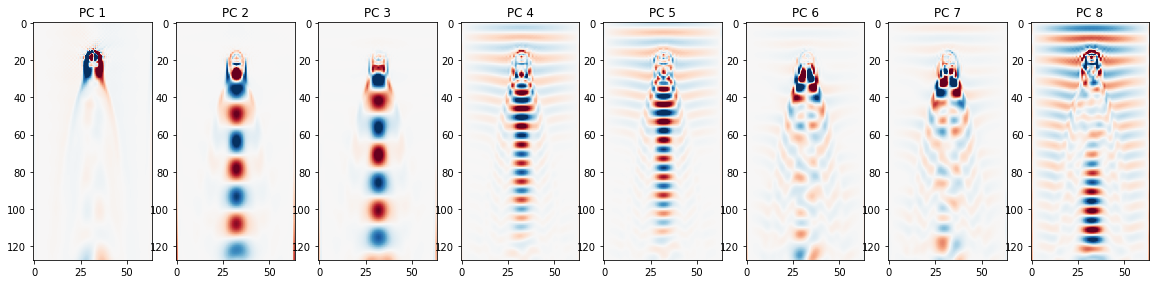

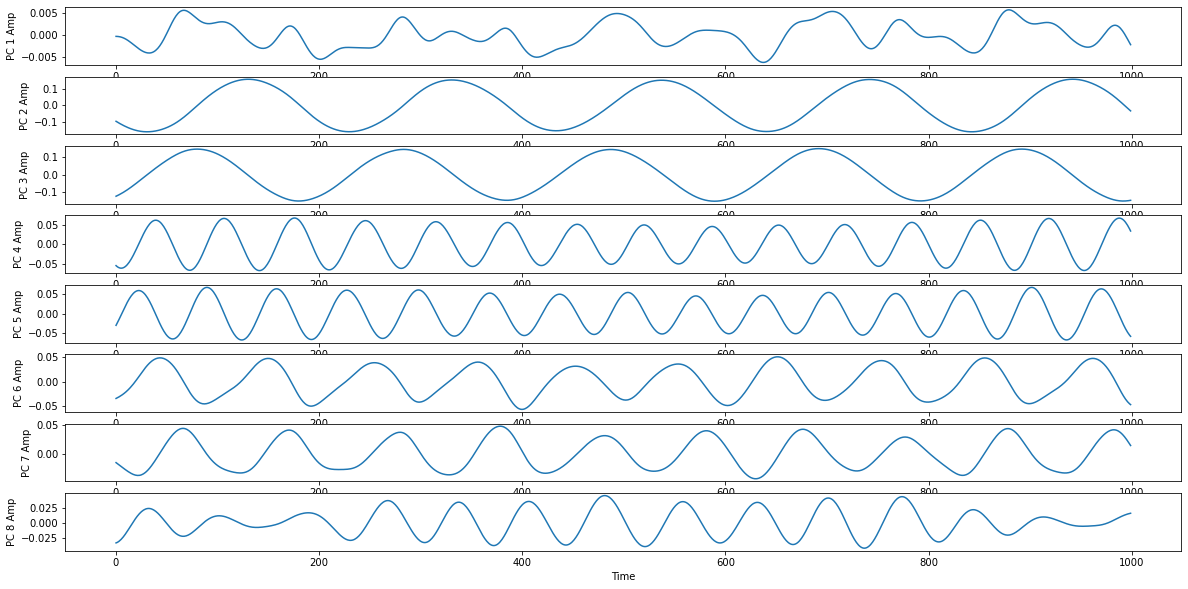

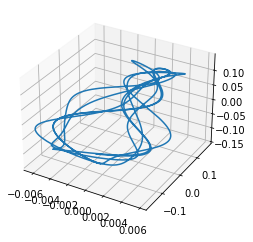

In [13]:
plt.figure(figsize=(20, 10))
for i in range(8):
    plt.subplot(1, 8, i+1)
    vscale = np.percentile(np.abs(principal_components[i]), 99)
    plt.imshow(principal_components[i], cmap="RdBu", vmin=-vscale, vmax=vscale)
    plt.title("PC {}".format(i+1))

plt.figure(figsize=(20, 10))
for i in range(8):
    plt.subplot(8, 1, i+1)
    plt.plot(data_transformed[:, i])
    plt.ylabel("PC {} Amp".format(i+1))
plt.xlabel("Time")

plt.figure()
ax = plt.axes(projection='3d')
ax.plot(data_transformed[:, 0], data_transformed[:, 1], data_transformed[:, 2])

1. What symmetries are present in the data? Do any symmetries change as we increase the Reynolds number?
In the data with Reynolds = 300, there are multiple pairs of symmetries with two low order symmetries that simply alternate in magnitude in a sort of oscillating manner as it propagates. These symmetries then get gradually more complex or "higher" order later on. Each element in a pair of symmetries could be considered to be the "flip" of the other. 
As the Reynolds number increases, even the lower order symmetries get much more complex.

2. What does the plot of descending eigenvalues tell us about the effective dimensionality, and thus the optimal number of features, to use to represent the von Karman dataset?

3. Using different Reynolds numbers, how does the effective dimensionality change as that number increases?
The effective dimensionality of the lower dimensionality increases as the Reynolds number increases since more of the eigenvalues are required to capture the essential features.

4. Why might the principal components appear in pairs?
Since each element in a pair could be considered to be the negative of the other, the modes that exist could be considered to have an odd parity especially about the vertical axis of the system. As for why these modes exist, I would guess that it mirrors some inherent symmetry in the features that cause the vortices to appear in the first place.

5. What happens if we don't subtract the feature-wise mean before calculating PCA?

Some of the same modes to still show up if we don't substract the feature-wise mean, but we also generate these isolated asymmetric modes that distort the overall flow. This is also evident in the phase space diagram of the transformed data, where the toroidal trajectory has effectively lost that order. 

6. In Fourier Analysis, we project a function onto a linear combination of trigonometric basis functions. How is this related to PCA?

There are definitely analogues to Fourier analysis, which projects a continuos or discrete function as described above. Likeise, PCA projects data onto a subset, but of eigenvectors of the dataset rather than a standard type of basis function. Both can be used to simplify complicated problems by eliminating higher order contributions/dimensions that have negligible contributions to the overall behavior. I haven't ever heard of Fourier Analysis being used to maximize the amount of variance captured in a data set relative to the number of dimensions, so that could also be a potential difference. 